## Практическое задание к уроку 14 по теме "Transfer learning".

*Взять данные из https://www.kaggle.com/datasets/mrapplexz/bashim-quotes  
обучить модель GPT для генерации своих цитат*

В данной задаче обучу с нуля модель GPT-2 и токенизатор для неё,  
а потом посмотрим, как она будет генерировать цитаты. Хоть тема  
урока, вроде бы, и предусматривает использование предобученной  
модели и дальнейшее её дообучение, но так мы часто делаем, и в  
этот раз хотелось бы всё сделать с нуля. В качестве transfer learning  
возьмём только архитектуру GPT-2.

Загрузим библиотеки и датасет:

In [1]:
%matplotlib inline

from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import re
from time import time
from tokenizers import Tokenizer
from tokenizers.decoders import WordPiece
from tokenizers.models import BPE
from tokenizers.normalizers import StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
import torch
from torch import nn
from torchinfo import summary
from transformers import GPT2Config, GPT2LMHeadModel
from tqdm import tqdm

In [2]:
RANDOM_STATE = 29

In [3]:
dataset = load_dataset('json', data_files='./dataset.jsonl', split='train')

Using custom data configuration default-93d1eaaef032e4bd
Found cached dataset json (/home/shkin/.cache/huggingface/datasets/json/default-93d1eaaef032e4bd/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


In [4]:
dataset

Dataset({
    features: ['id', 'date', 'rating', 'text'],
    num_rows: 81497
})

In [5]:
pd.DataFrame(dataset[:5])

,id,date,rating,text
0,1,2004-08-30 11:24:00,22010,"<Ares> ppdv, все юниксы очень дружелюбны.. они..."
1,2,2004-08-30 11:25:00,25105,<томатик_рад> а ты не чувствуешь красоту мира?...
2,3,2004-08-30 11:27:00,7192,"<Дор> ""мышка, почему у тебя такие большие глаз..."
3,4,2004-08-30 11:28:00,29169,"<PPDV[os2]> ""Мальчики, вы что больные, бегать ..."
4,5,2004-08-30 11:26:00,7140,<Ohtori_Akio> мы - как разработчики - живём с ...


In [6]:
train = dataset['text']

In [7]:
train[:10]

['<Ares> ppdv, все юниксы очень дружелюбны.. они просто очень разборчивы в друзьях ;)',
 '<томатик_рад> а ты не чувствуешь красоту мира?\n<fox> честно говоря, я сейчас чувствую только отсутствие http.\n<томатик_рад> не туда смотришь, глянь вокруг!\n<fox> как я гляну, если http не работает? :/',
 '<Дор> "мышка, почему у тебя такие большие глаза?" УЙДИ!!! я ХАРАКИРИ делаю!!!!!!',
 '<PPDV[os2]> "Мальчики, вы что больные, бегать в палату к девочкам?! - Если б мы были больные - мы б бегали к другим мальчикам"',
 '<Ohtori_Akio> мы - как разработчики - живём с субейзом под одбц. \n<Ohtori_Akio> лучше бы мы жили в пещере с гоблинами.',
 '<Ohtori_Akio> о чём ни спроси - все обычно советуют сменить операционку, потом железо, потом страну пребывания, ориентацию, всё, что угодно... вместо того, чтобы подсказать нужную настройку в софтине.',
 '<Hellcat> Настояший программер пьёт один раз в день - с утра и до вечера',
 '<Kosh_подстригся> мой критерий в аниме - много крови и много теток с эээ... тетк

Напишем функцию предобработки. В ней буду заменять ники  
пользователей в угловых скобках на числа для обобщения.  
Также добавлю специальные токены. Несмотря на то, что  
можно задать правило для пост-обработчика (post_processor)  
токенайзера и автоматизировать этот процесс, настройка  
недостаточно гибкая, так как я хотел бы разделять цитаты  
каждого пользователя спецтокеном \[SEP\] и при этом подавать  
всю цитату целиком. В пост-обработчике нельзя разделить  
текст на части, а подавать текст парами тоже не вариант,  
так как иногда количество реплик в цитате более двух.

In [8]:
def preprocess(text):
    text = '[CLS] ' + text + ' [EOS]'
    text = re.sub('\n', ' [SEP]\n', text)
    users = re.findall('<.+?>', text)
    
    if len(users) > 1:
        for user in users:
            text = text.replace(user, str(users.index(user)) + ':')
    
    # Если пользователь один, то убираем его ник
    elif users:
        text = text.replace(users[0], '')

    return text

Посмотрим, как будет выглядеть результат предобработки:

In [9]:
print(preprocess(train[1]))

[CLS] 0: а ты не чувствуешь красоту мира? [SEP]
1: честно говоря, я сейчас чувствую только отсутствие http. [SEP]
0: не туда смотришь, глянь вокруг! [SEP]
1: как я гляну, если http не работает? :/ [EOS]


Инициализируем токенайзер, за его основу возьмём алгоритм BPE,  
он используется и в предобученной GPT-2:

In [10]:
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))

Зададим нормализатор токенайзера, который будет сразу убирать  
ударения слов:

In [11]:
normalizer = StripAccents()
tokenizer.normalizer = normalizer

Зададим претокенайзер, который будет разделять текст на  
токены по пробелам, а также выделять пунктуацию в отдельные  
токены. Здесь имеем отличие от предобученной GPT-2, в которой  
используется ByteLevel.

In [12]:
pretokenizer = Whitespace()
tokenizer.pre_tokenizer = pretokenizer

Зададим размер словаря:

In [13]:
VOCAB_SIZE = 5000

Зададим трейнер, который будет обучать токенайзер:

In [14]:
trainer = BpeTrainer(vocab_size=VOCAB_SIZE,
                     special_tokens=['[UNK]', '[CLS]', '[SEP]', '[PAD]', '[EOS]'],
                     continuing_subword_prefix='##',
                     show_progress=True)

Обработаем тексты и посмотрим на них:

In [15]:
train_processed = [preprocess(text) for text in train]

In [16]:
train_processed[:5]

['[CLS]  ppdv, все юниксы очень дружелюбны.. они просто очень разборчивы в друзьях ;) [EOS]',
 '[CLS] 0: а ты не чувствуешь красоту мира? [SEP]\n1: честно говоря, я сейчас чувствую только отсутствие http. [SEP]\n0: не туда смотришь, глянь вокруг! [SEP]\n1: как я гляну, если http не работает? :/ [EOS]',
 '[CLS]  "мышка, почему у тебя такие большие глаза?" УЙДИ!!! я ХАРАКИРИ делаю!!!!!! [EOS]',
 '[CLS]  "Мальчики, вы что больные, бегать в палату к девочкам?! - Если б мы были больные - мы б бегали к другим мальчикам" [EOS]',
 '[CLS] 0: мы - как разработчики - живём с субейзом под одбц.  [SEP]\n0: лучше бы мы жили в пещере с гоблинами. [EOS]']

Обучим токенайзер на этих текстах:

In [17]:
tokenizer.train_from_iterator(train_processed, trainer=trainer)

Убедимся, что в текстах хватило токенов для нашего словаря:

In [18]:
len(tokenizer.get_vocab())

5000

In [19]:
tokenizer.get_vocab_size()

5000

Для расшифровки сгенерированных текстов зададим декодер.  
Он также отличен от декодера ByteLevel, используемого в  
предобученной GPT-2.

In [20]:
tokenizer.decoder = WordPiece()

Посмотрим, как токенизатор кодирует и декодирует:

In [21]:
print(tokenizer.encode(train_processed[4]).tokens)

['[CLS]', '0', ':', 'мы', '-', 'как', 'разработ', '##чики', '-', 'жив', '##ём', 'с', 'суб', '##ей', '##зом', 'под', 'од', '##б', '##ц', '.', '[SEP]', '0', ':', 'лучше', 'бы', 'мы', 'жи', '##ли', 'в', 'пе', '##щ', '##ере', 'с', 'го', '##бли', '##нами', '.', '[EOS]']


In [22]:
print(tokenizer.encode(train_processed[4]).ids)

[1, 21, 31, 1047, 18, 880, 2876, 3194, 18, 2921, 1487, 256, 3729, 887, 4506, 932, 1037, 491, 477, 19, 2, 21, 31, 1641, 876, 1047, 1058, 830, 241, 1511, 520, 883, 256, 886, 1793, 2496, 19, 4]


In [23]:
tokenizer.decode(tokenizer.encode(train_processed[4]).ids)

'0 : мы - как разработчики - живём с субейзом под одбц. 0 : лучше бы мы жили в пещере с гоблинами.'

Для принятия решения о длине текстов построим гистограмму длин токенов:

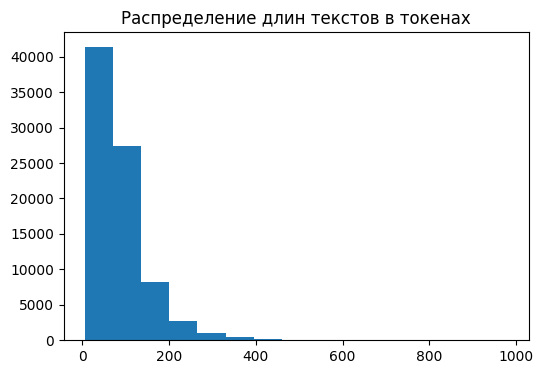

In [24]:
plt.figure(figsize=(6, 4))

plt.hist([len(tokenized.ids) for tokenized in tokenizer.encode_batch(train_processed)], bins=15)
plt.title('Распределение длин текстов в токенах')
plt.show()

Будем использовать длину текстов в 512 токенов. Предобученная  
GPT-2 использует 1024 токена.

In [25]:
MAX_LEN = 512

Зададим режим паддинга и truncation для токенайзера:

In [26]:
tokenizer.token_to_id('[PAD]')

3

In [27]:
tokenizer.enable_padding(pad_id=3, length=MAX_LEN)

In [28]:
tokenizer.enable_truncation(max_length=MAX_LEN)

Зададим конфиг для модели GPT-2. В дефолтном конфиге  
поменяем значение длины текстов и размер словаря. Также  
укажем айдишники специальных токенов.

In [29]:
tokenizer.token_to_id('[CLS]')

1

In [30]:
tokenizer.token_to_id('[EOS]')

4

In [31]:
config = GPT2Config(vocab_size=VOCAB_SIZE, 
                    bos_token_id=1, 
                    eos_token_id=4,
                    n_positions=MAX_LEN)
config

GPT2Config {
  "activation_function": "gelu_new",
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 4,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 512,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 5000
}

Данный конфиг соответствует модели GPT-2 SMALL с 12 слоями  
и размером эмбеддингов 768. Мы поменяли под нашу задачу только  
длину текстов и размер словаря.

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Напишем класс датасета. В нём будем делать токенизацию и формирование  
словаря для передачи модели. В качестве таргетов будут токены, следующие  
за текущим:

In [33]:
class BashDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.encodings = tokenizer.encode_batch(data)

    def __getitem__(self, index):
        encoding = self.encodings[index]
            
        dictionary = {'input_ids': torch.IntTensor(encoding.ids).to(device),
                      'attention_mask': torch.IntTensor(encoding.attention_mask).to(device),
                      'token_type_ids': torch.IntTensor(encoding.type_ids).to(device)
                     }
        
        inputs = {k: v[:-1] for k, v in dictionary.items()}
        labels = dictionary['input_ids'][1:]
        
        return inputs, labels.long()
    
    def __len__(self):
        return len(self.encodings)

Создадим даталоадер. Размер батча мал, но бОльшие значения  
приводят к ошибке нехватки памяти при обучении.

In [34]:
dataset = BashDataset(train_processed)

In [35]:
BATCH_SIZE = 4

In [36]:
torch.random.manual_seed(RANDOM_STATE)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

Посмотрим на модель:

In [37]:
summary(GPT2LMHeadModel(config))

Layer (type:depth-idx)                             Param #
GPT2LMHeadModel                                    --
├─GPT2Model: 1-1                                   --
│    └─Embedding: 2-1                              3,840,000
│    └─Embedding: 2-2                              393,216
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─GPT2Block: 3-1                         7,087,872
│    │    └─GPT2Block: 3-2                         7,087,872
│    │    └─GPT2Block: 3-3                         7,087,872
│    │    └─GPT2Block: 3-4                         7,087,872
│    │    └─GPT2Block: 3-5                         7,087,872
│    │    └─GPT2Block: 3-6                         7,087,872
│    │    └─GPT2Block: 3-7                         7,087,872
│    │    └─GPT2Block: 3-8                         7,087,872
│    │    └─GPT2Block: 3-9                         7,087,872
│    │    └─GPT2Block: 3-10                        7,087

Итого нам нужно с нуля обучить 89 млн. параметров.

Напишем функцию для более красивого вывода времени,  
затраченного на обучение:

In [38]:
def calc_time(start, end):
    diff = end - start
    mins = diff // 60
    secs = diff % 60
    return f'{int(mins)} min {int(secs)} s'

Напишем функцию обучения. В рамках функции есть возможность  
дообучать модель, а также происходит сохранение модели в конце  
каждой эпохи.

In [39]:
def train_nn(epochs=5, lr=5e-5, warm_start=False, model=None):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    
    if not warm_start:
        net = GPT2LMHeadModel(config).to(device)
    
    else:
        assert model is not None, 'Нужно передать модель в функцию, т.к. warm_start=True'
        net = model
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        start_time = time()
        losses = 0.

        for inputs, labels in tqdm(loader):
            net.train()

            optimizer.zero_grad()
            outputs = net(**inputs)[0].permute(0, 2, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses += loss.item()
        
        net.save_pretrained('./model/')
        
        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Loss: {losses / len(loader):.3f}. ' \
              f'Time: {calc_time(start_time, time())}.')

    print('Training is finished!')
    return net

Обучим модель:

In [40]:
model = train_nn(epochs=8)

100%|███████████████████████████████████| 20375/20375 [1:34:17<00:00,  3.60it/s]


Epoch [1/8]. Loss: 0.904. Time: 94 min 18 s.


100%|███████████████████████████████████| 20375/20375 [1:31:45<00:00,  3.70it/s]


Epoch [2/8]. Loss: 0.748. Time: 91 min 46 s.


100%|███████████████████████████████████| 20375/20375 [1:28:26<00:00,  3.84it/s]


Epoch [3/8]. Loss: 0.686. Time: 88 min 27 s.


100%|███████████████████████████████████| 20375/20375 [1:36:42<00:00,  3.51it/s]


Epoch [4/8]. Loss: 0.646. Time: 96 min 43 s.


100%|███████████████████████████████████| 20375/20375 [1:29:48<00:00,  3.78it/s]


Epoch [5/8]. Loss: 0.617. Time: 89 min 50 s.


100%|███████████████████████████████████| 20375/20375 [1:26:58<00:00,  3.90it/s]


Epoch [6/8]. Loss: 0.592. Time: 86 min 59 s.


100%|███████████████████████████████████| 20375/20375 [1:26:57<00:00,  3.91it/s]


Epoch [7/8]. Loss: 0.569. Time: 86 min 59 s.


100%|███████████████████████████████████| 20375/20375 [1:26:56<00:00,  3.91it/s]


Epoch [8/8]. Loss: 0.548. Time: 86 min 57 s.
Training is finished!


Напишем функцию для генерации цитат:

In [57]:
def generate_text():
    text = model.generate(
           pad_token_id=3,
           bos_token_id=1,
           eos_token_id=4,
           max_new_tokens=512,
           # do_sample=True,
           # temperature=1.0,
           num_beams=15,
           # top_k=10,
           repetition_penalty=5.
           )
    
    text = tokenizer.decode(text[0].tolist())
    
    # Обработаем тексовую выдачу. Добавим символы переноса строки,  
    # где они должны быть
    text = re.sub(r'\s{1}([xyz]{3})', r'\n\1', text)
    print(text, end='\n\n')
    print('*' * 100, end='\n\n')

Посмотрим на результаты работы модели:

In [61]:
for _ in range(10):
    generate_text()

xxx : В детстве я мечтал стать космонавтом, что - то у меня появилось впечатление, что несмотря на то, что мне кажется, выросло соединение.

****************************************************************************************************

xxx : В детстве я мечтал стать космонавтом.
xxx : С тех пор никто не знал, что такое дедушка Мороз...

****************************************************************************************************

xxx : у нас на работе есть сотрудник с фамилией Петровича.
xxx : ну и как он там?

****************************************************************************************************

xxx : у нас на работе есть сотрудник, который работает в одном крупном отделе.
yyy : и что?
xxx : начальник отдела управления проектированием занимает работу по собственному предназначению с организационными требованиями квалифицированных услуг :)

****************************************************************************************************

xxx : У нас на р

</ins>Вывод:</ins>  
Инициализировали своим конфигом и обучили модель GPT-2 с токенизатором.  
Обучение одной эпохи занимало примерно полтора часа, поэтому пришлось  
ограничить количество эпох, и результат генерации получился не очень  
впечатляющим. Видно, что часто генерация начинается с одних и тех же слов,  
но это ввиду отсутствия сэмплирования. При включении сэмплирования, модель  
начинает генерировать совсем уж невнятный набор слов из-за недообучения.  
Также на качестве генерирования мог сказаться относительно небольшой размер  
словаря, но при его увеличении нужно будет ещё больше времени на обучение.  
По итогу задания, отлично попрактиковались в полном цикле обучения модели  
transformers и перечитали много соответствующей документации.